# **Reducing APF Data Tutorial**
By Zoe Ko

## About this tutorial

This tutorial is intended to show the progression of APF 1D data products. Begin with the reduced 1D spectra and follow four steps to reduce the data:
* Deblaze and normalize the data by dividing out the echelle blaze function
* Transform the wavelength solution of the data to constant RV space
* Download a corresponding synthetic or empirical spectrum and transform its wavelength solution to constant RV space
* Run a chi-squared test on the data and the empirical spectrum to determine doppler shift
* Shift the data to be in the rest frame


## About the data

The APF data can be downloaded from the Breakthrough Listen database, which can be found through the [Breakthrough Listen webpage](https://seti.berkeley.edu/listen/data.html). The solar flux spectrum can be found from [NSO](https://drive.google.com/file/d/12ByZSN1k6MOXBqOO-6Dpqrp1HvHr8b6z/view?usp=sharing).

In [298]:
from astropy.io import fits
import matplotlib.pylab as plt
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep

## Read in APF Data

This tutorial uses 10 CVn (HIP62207), an F type star. It takes spectra from order 38, which includes wavlengths from approximately 5380 to 5460 Angstroms.

In [299]:
star = 'HIP62207'
APF_wavelength_path = '/mnt_home/zoek/APF_tutorial/apf_wav.fits'
APF_flux_path = '/datag/blpd0/datax/apf/rarj.224.fits'

wl_file = fits.open(APF_wavelength_path)
fl_file = fits.open(APF_flux_path)
wl_image = wl_file[0].data
fl_image = fl_file[0].data

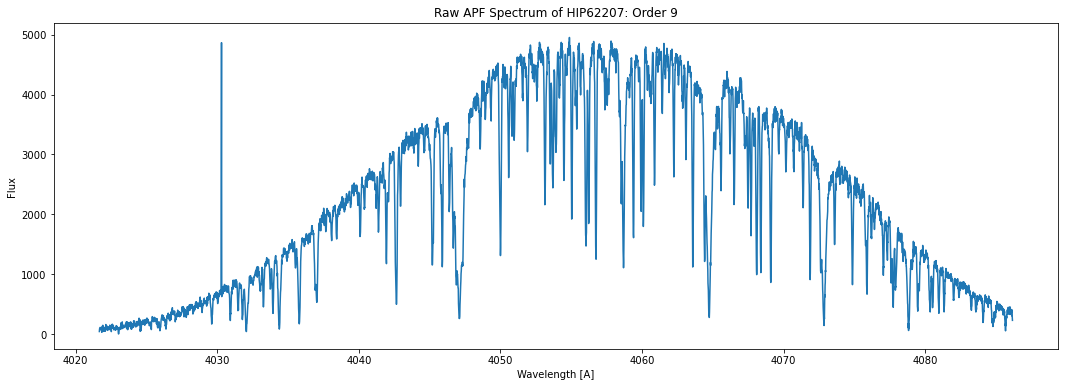

In [300]:
plt.rcParams["figure.figsize"] = (18,6)

order = 9
wl = wl_image[order]
flux = fl_image[order][:-1]
plt.plot(wl,flux)

plt.title('Raw APF Spectrum of ' + star + ': Order ' + str(order))
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()

## Dividing out the Echelle Blaze Function

Divide the data into bins of 100 pixels. Find the flux value in the 95th percentile within each bin and plot these flux values onto the wavelength values. Divide the APF flux spectrum by the fit of the 95th percentile flux values.

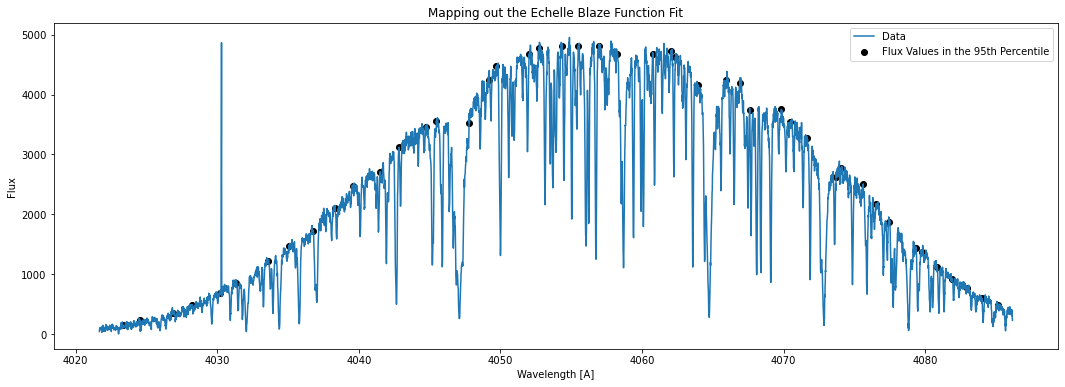

In [301]:
bin = 100

# this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
indices = []

for i in np.arange((len(wl) - (bin)), step = bin):
    flux_values = []
    for j in np.arange(i, i + bin, step = 1):
        value = flux[j]
        flux_values = np.append(flux_values, value)
    # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
    # but avoid issues with cosmic rays and other emission lines
    flux_in_bin = np.percentile(flux_values, 95)
    # find the closest value in the flux array to the 95th percentile value
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i + index_in_bin
    indices = np.append(indices, index)

# these lists will contain the wavlength and flux values at each index in 'indices'
wl_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wl_values = np.append(wl_values, wl[ind])
    fl_values = np.append(fl_values, flux[ind])
    
plt.plot(wl, flux, label = 'Data')
plt.scatter(wl_values, fl_values, color = 'black', label = 'Flux Values in the 95th Percentile')
plt.title('Mapping out the Echelle Blaze Function Fit')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

Plot fl_values onto wl_values so that the length of the arrays match that of the APF spectrum. Set s to 500000 to smooth the fit.

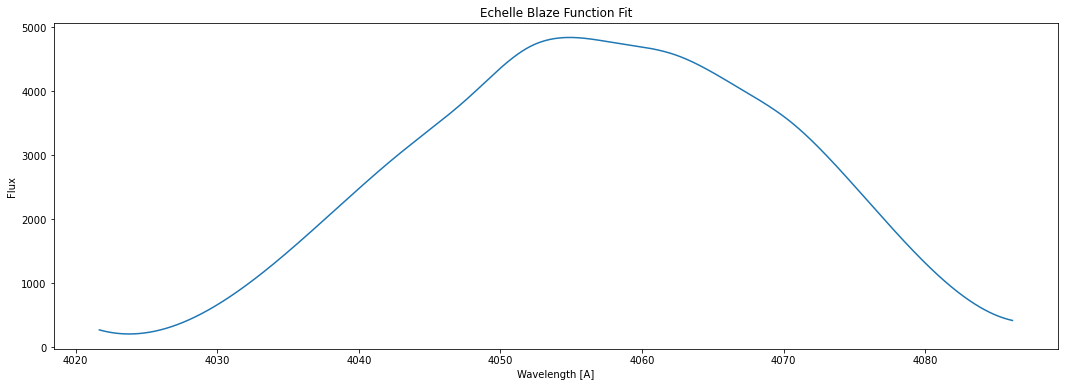

In [302]:
spl = splrep(wl_values, fl_values, s = 500000)
flux_fit = splev(wl, spl)
plt.plot(wl, flux_fit)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Echelle Blaze Function Fit')
plt.show()

Divide out the fit from the data.

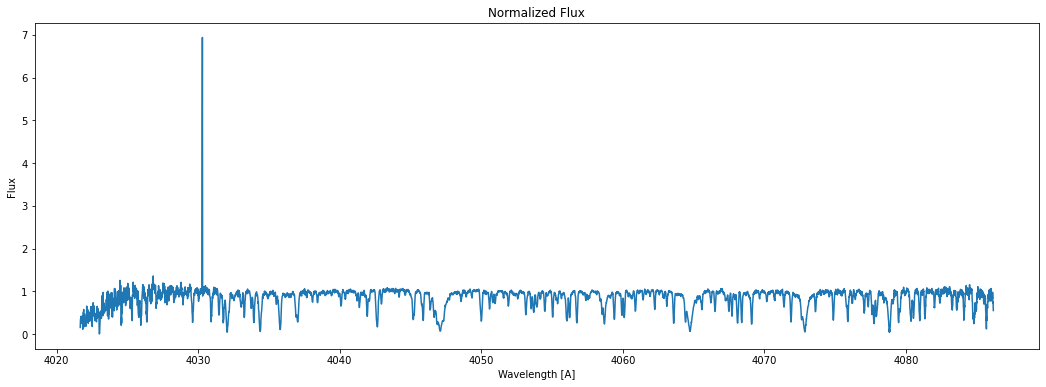

In [303]:
first_normalized_flux = flux / flux_fit
plt.plot(wl, first_normalized_flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Normalized Flux')
plt.show()

However, this spectra is not well normalized because the values in each bin were drawn from the 95th percentile. Do another normalization by finding the 98th percentile of the data and dividing the data by that value to ensure that the continuum is at 1.0.

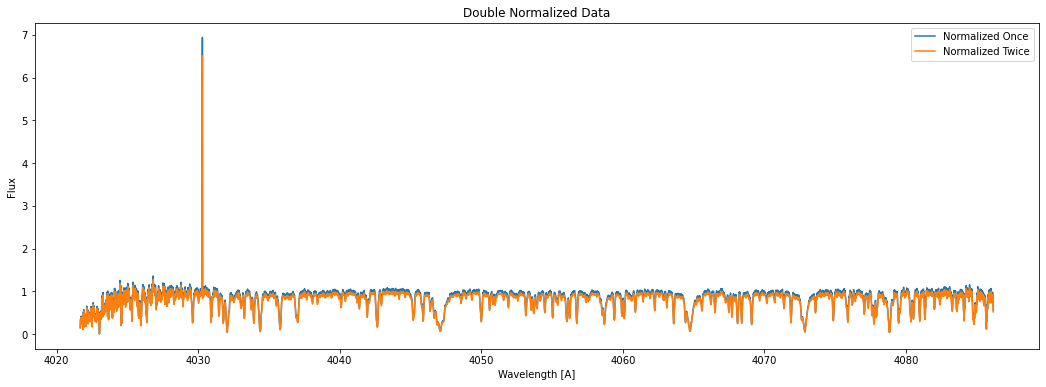

In [304]:
flux98 = np.percentile(first_normalized_flux, 98)
normalized_flux = first_normalized_flux / flux98

plt.plot(wl, first_normalized_flux, label = 'Normalized Once')
plt.plot(wl, normalized_flux, label = 'Normalized Twice')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Double Normalized Data')
plt.show()

Now we have a normalized spectrum with its continuum at 1.0.

## Regriding the Wavelength Grid to be in Constant RV Space
Plot the normalized flux values onto the original wavelength grid, create a new wavelength grid that is log lambda spaced, and then interpolate onto the new wavelength grid. This will create a spectrum that is in constant RV space, which will allow for a straightforward calculation of the Doppler shift.

In [305]:
f = scipy.interpolate.interp1d(wl, normalized_flux, kind='cubic')

In [306]:
#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 # km/s
C = 299792.458 #km/s
wl_start = min(wl) + 0.2
wl_end = max(wl) - 0.2

CDELT1 = np.log10(dv/C +1) # wavelength grid step size

CRVAL1 = np.log10(wl_start)  # log of starting wavelength value
CRVALN = np.log10(wl_end)    # log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) / CDELT1  # total number of points

p = np.arange(NAXIS1) # array of total points
wl = 10 ** (CRVAL1 + CDELT1 * p)  # new array of wavelength values

# interpolate flux values onto log spaced wavelength grid
flux = f(wl)

Plot the new wavelength grid against flux values. This should look the same as before; however, the wavelengths are now velocity spaced.

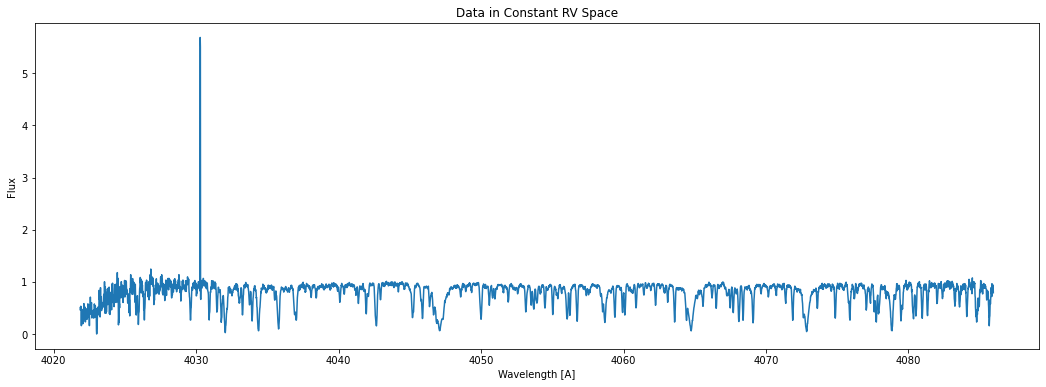

In [307]:
plt.plot(wl, flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Data in Constant RV Space')
plt.show()

## Empirical Solar Spectrum
Read the empirical solar spectrum using astropy.io.fits. There are two arrays: one is the wavelength from around 3000 angstroms to 12,500 Angstroms, and the second is the corresponding flux array. Truncate it to match the wavelength range of the APF data. 

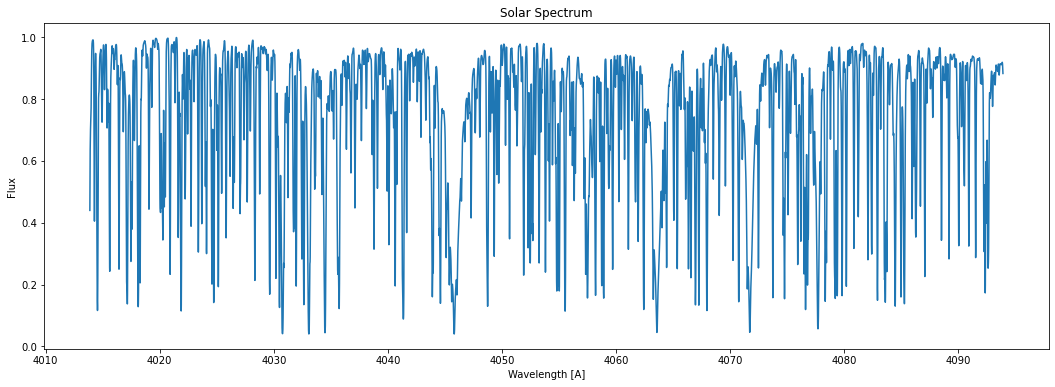

In [308]:
solar_spectrum_path = '/mnt_home/zoek/APF_tutorial/nso.fits'

solar_spectrum = fits.open(solar_spectrum_path)
wl_temp = solar_spectrum[0].data
fl_temp = solar_spectrum[1].data

# wavelengths of APF data
min_wl = min(wl) - 8
absolute_difference_function = lambda list_value : abs(list_value - min_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
min_index = wl_temp.tolist().index(w)

max_wl = max(wl) + 8
absolute_difference_function = lambda list_value : abs(list_value - max_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
max_index = wl_temp.tolist().index(w)

wl_syn_temp = wl_temp[min_index:max_index]
fl_syn_temp = fl_temp[min_index:max_index]

plt.plot(wl_syn_temp, fl_syn_temp)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum')
plt.show()

Regrid the synthetic spectrum to be log lambda spaced (contant velocity).

In [309]:
f = scipy.interpolate.interp1d(wl_syn_temp, fl_syn_temp, kind='cubic')

In [310]:
#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 #km/s
C = 299792.458 #km/s
wl_start = min(wl_syn_temp) + 0.2
wl_end = max(wl_syn_temp) - 0.2

CDELT1 = np.log10(dv/C +1) #wavelength grid step size

CRVAL1 = np.log10(wl_start)  #log of starting wavelength value
CRVALN = np.log10(wl_end)    #log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) /CDELT1  #total number of points

p = np.arange(NAXIS1) #array of total points
wl_syn = 10 ** (CRVAL1 + CDELT1 * p)  #array of wavelength values

# interpolate flux values onto log spaced wavelength grid
fl_syn = f(wl_syn)

Plot the new wavelength grid against flux values. This should look the same as before; however, the wavelengths are now velocity spaced.

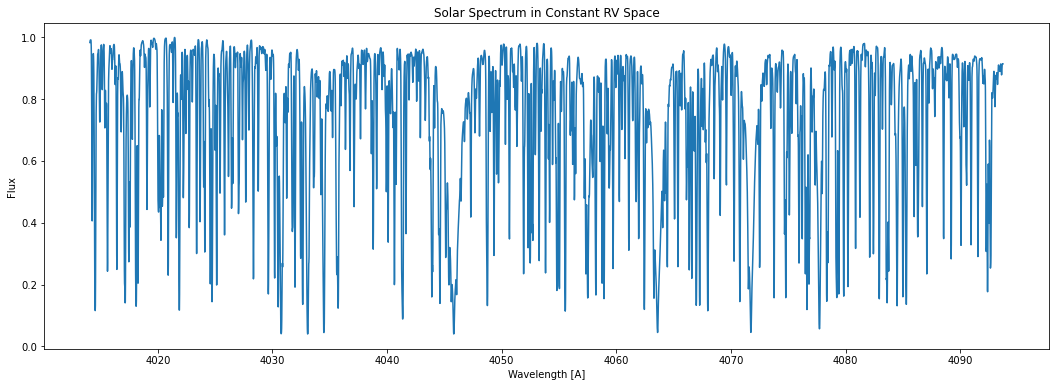

In [311]:
plt.plot(wl_syn, fl_syn)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum in Constant RV Space')
plt.show()

## Finding the velocity shift of the data from the empirical spectrum

First find the current offset of the APF spectrum and the empirical spectrum.

In [312]:
for wavelength in wl_syn:
    if (min(wl) - 0.02) < wavelength < (min(wl) + 0.02):
        x = wavelength

index = wl_syn.tolist().index(x)
print('The first value of the APF data is located at pixel ' + str(index) + ' of the empirical spectrum.')

The first value of the APF data is located at pixel 583 of the empirical spectrum.


Run a chi-squared test to determine the offset of the data and the empirical spectrum. The chi-squared test will scan the data against the synthetic spectrum: it will begin where the first pixels of each spectrum line up and end where the last pixels of each spectrum line up. The test will calculate the residual at each location. When the two spectra line up, the residual will be minimized, resulting in a minimum in the chi-squared plot. 

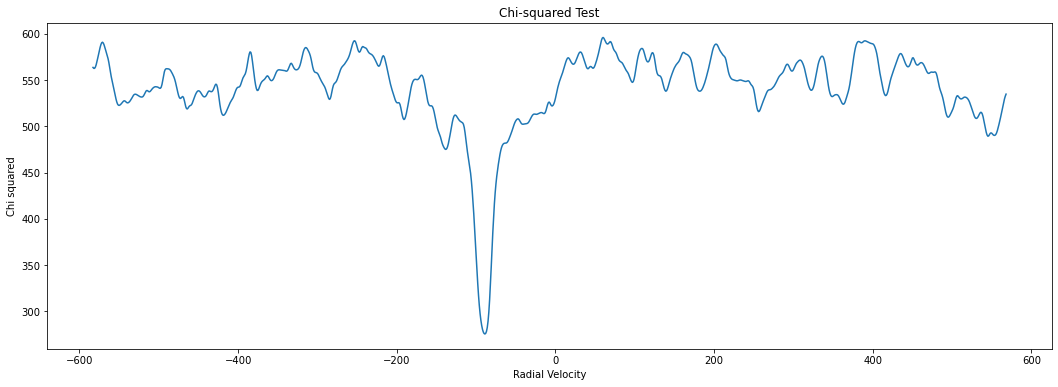

HIP62207 is traveling toward Earth at 89 km/s. The APF spectrum needs to be redshifted by 89 pixels. (Shift to left.)


In [313]:
def chi(model, data):
    '''given two arrays of the same length,
    calculate chi squared'''
    return np.sum((data - model) ** 2)

chi_squared_values = []
indices = []

for i in np.arange(len(wl_syn) - len(wl)):
    syn_flux = fl_syn[i: i + len(wl)]
    chi_squared = chi(syn_flux, flux)
    chi_squared_values = np.append(chi_squared_values, chi_squared)
    indices = np.append(indices, i)
    
min_chi = min(chi_squared_values)
shifted_index = chi_squared_values.tolist().index(min_chi)

plt.plot(indices - index, chi_squared_values)
plt.xlabel('Radial Velocity')
plt.ylabel('Chi squared')
plt.title('Chi-squared Test')
plt.show()

if (shifted_index - index) < 0:
    shift = index - shifted_index
    print(star + ' is traveling toward Earth at ' + str(shift) + ' km/s. The APF spectrum needs to be redshifted by ' + str(shift) + ' pixels. (Shift to left.)')
    shift_dir = 'left'
else:
    shift = shifted_index - index
    print(star + ' is traveling away from Earth at ' + str(shift) + ' km/s. The APF spectrum needs to be blueshifted by ' + str(shift) + ' pixels. (Shift to right.)')
    shift_dir = 'right'

The minimum chi-squared value occurs where the residual between the data and the empirical spectrum is minimized, indicating a best fit. The noise around this minimum represent RV values where the data happens to fit better or worse with the empirical spectrum.

Make a plot of the unshifted APF spectrum against the empirical spectrum.

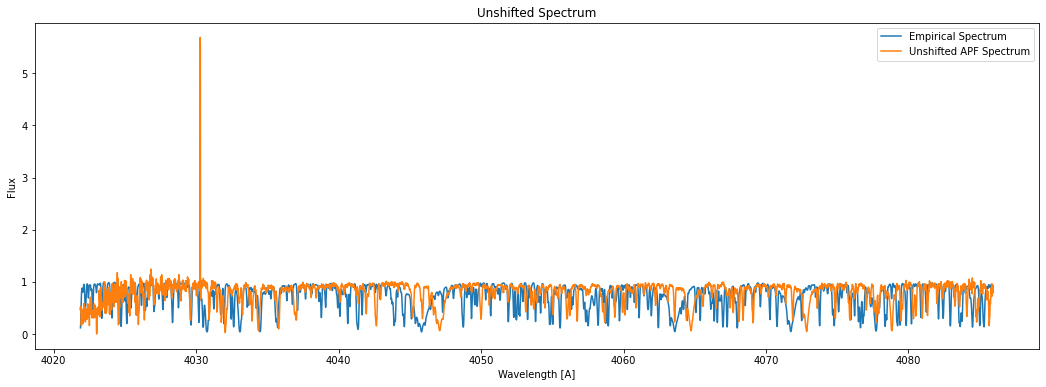

In [314]:
wl_syn_plot = wl_syn[index:-index]
fl_syn_plot = fl_syn[index:-index]

if shift_dir == 'left':
    shifted_wl = wl[:-shift]
    shifted_fl = flux[shift:]
else:
    shifted_wl = wl[shift:]
    shifted_fl = flux[:-shift]

plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(wl, flux, label = 'Unshifted APF Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Unshifted Spectrum')
plt.legend()
plt.show()

Zoom in to a smaller region of the plot to better visualize the offset between the data and the empirical spectrum.

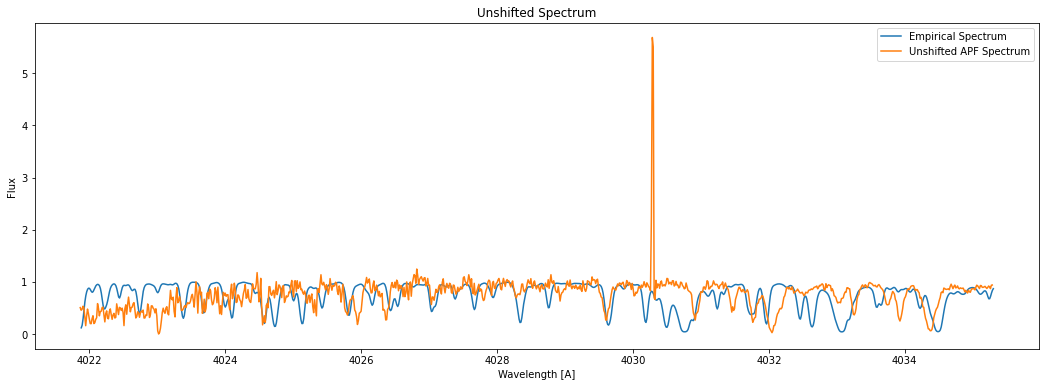

In [315]:
wl_syn_plot = wl_syn[index:-index]
fl_syn_plot = fl_syn[index:-index]

if shift_dir == 'left':
    shifted_wl = wl[:-shift]
    shifted_fl = flux[shift:]
else:
    shifted_wl = wl[shift:]
    shifted_fl = flux[:-shift]

plt.plot(wl_syn_plot[0:1000], fl_syn_plot[0:1000], label = 'Empirical Spectrum')
plt.plot(wl[0:1000], flux[0:1000], label = 'Unshifted APF Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Unshifted Spectrum')
plt.legend()
plt.show()

Plot the residuals.

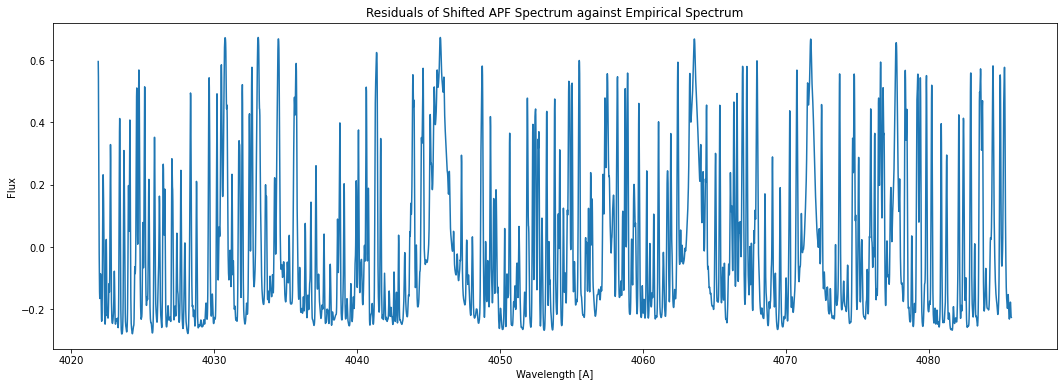

The average residual is -0.00828136950403609


In [316]:
residuals_unshifted = flux[len(wl_syn_plot)] - fl_syn_plot
plt.plot(wl_syn_plot, residuals_unshifted)
 
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Residuals of Shifted APF Spectrum against Empirical Spectrum')
plt.show()

print('The average residual is ' + str(np.average(residuals_unshifted)))

Now make a plot of the shifted APF spectrum against the empirical spectrum. The data should line up with the empirical spectrum much better.

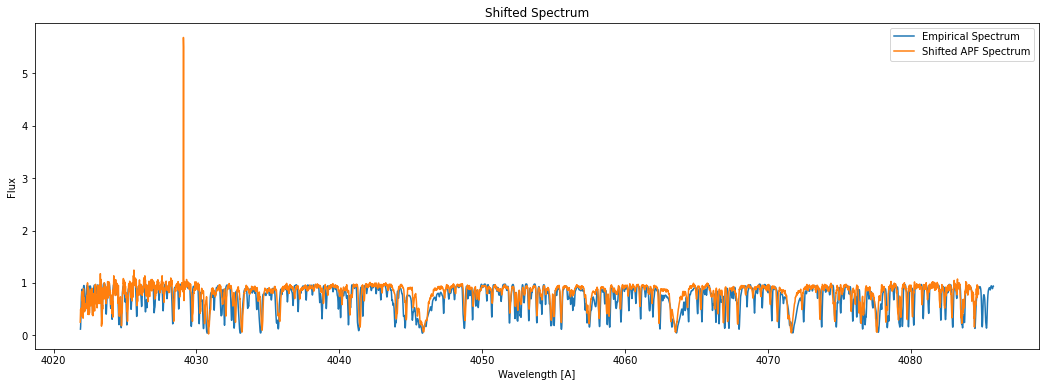

In [317]:
plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(shifted_wl, shifted_fl, label = 'Shifted APF Spectrum')

plt.title('Shifted Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

Zoom in to a smaller region of the plot to better visualize the difference.

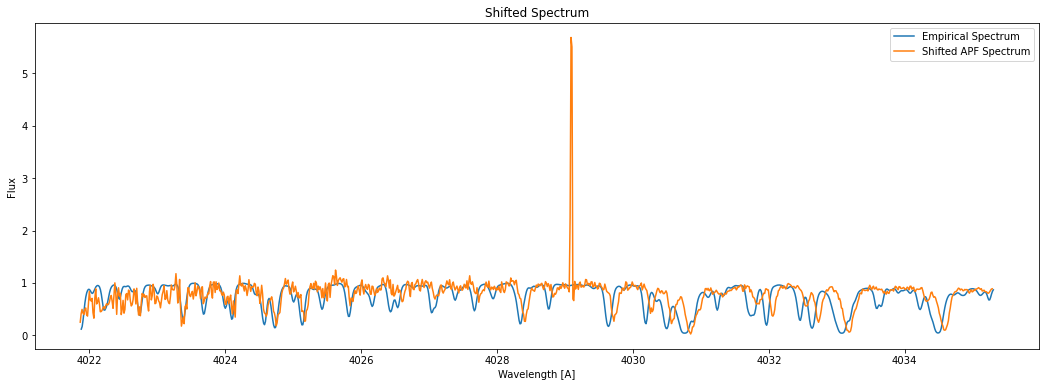

In [318]:
plt.plot(wl_syn_plot[0:1000], fl_syn_plot[0:1000], label = 'Empirical Spectrum')
plt.plot(shifted_wl[0:1000], shifted_fl[0:1000], label = 'Shifted APF Spectrum')

plt.title('Shifted Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

The residuals should be much lower.

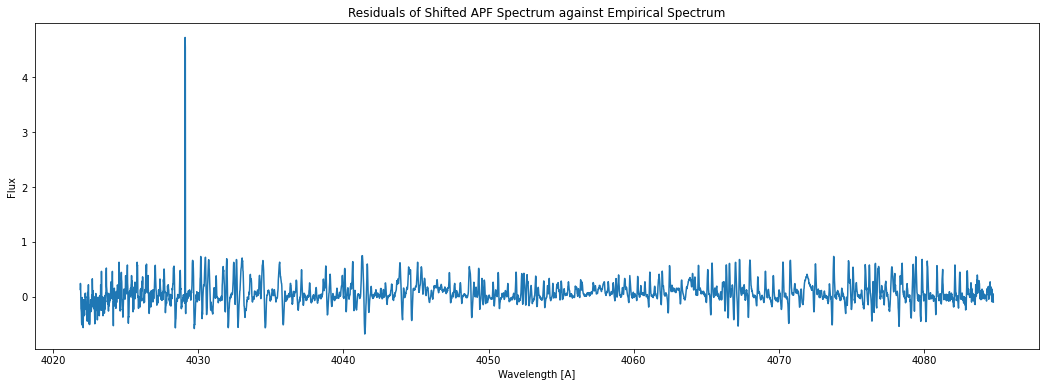

In [319]:
residuals_shifted = shifted_fl - fl_syn_plot[:len(shifted_wl)]
plt.plot(wl_syn_plot[:len(shifted_wl)], residuals_shifted)

plt.title('Residuals of Shifted APF Spectrum against Empirical Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()

## Final Product
Now we have a normalized, deblazed APF spectrum, shifted so that it is in its rest frame.

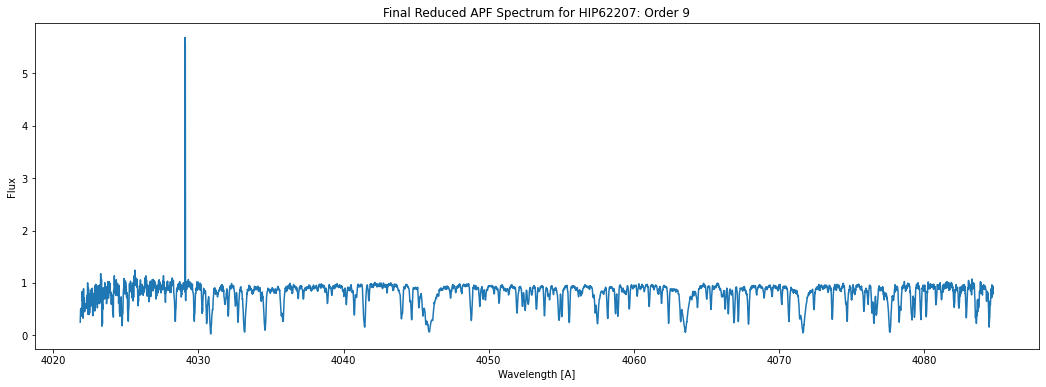

In [320]:
plt.plot(shifted_wl, shifted_fl)
plt.title('Final Reduced APF Spectrum for ' + star + ': Order ' + str(order))
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()